In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1)

In [64]:
data = pd.read_csv("data/datahw2.csv").drop("Id",axis=1)

In [65]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## preprocessing

In [66]:
# data.info()

решил убрать признаки у которых слишком мало не nan

In [67]:
cat = ["MiscFeature", "Fence", "PoolQC","FireplaceQu","MasVnrType","MasVnrType","Alley"]
data = data.drop(cat,axis=1)
data = data.dropna()
print(data.shape)

(1094, 74)


In [68]:
target = data["SalePrice"]
data = data.drop("SalePrice",axis=1)

Чтобы графики были адекватными

In [69]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

target = ss.fit_transform(target.values.reshape(-1,1))
target = target.ravel()

In [70]:
from sklearn.preprocessing import LabelEncoder

class autoLabelEncoder:
    def __init__(self) -> None:
        self.cat_encoders:dict = {}

    def fit(self, data:pd.DataFrame, categories:list[str]) -> None:
        for feat in categories:
            enc = LabelEncoder()
            self.cat_encoders[feat] = enc.fit(data.loc[data[feat].notna(), feat])

    def transform(self, data:pd.DataFrame, categories:list[str]) -> pd.DataFrame:
        for feat in categories:
            if(feat in data.columns):
                enc = self.cat_encoders[feat]
                data.loc[data[feat].notna(), feat] = (enc.transform(data.loc[data[feat].notna(), feat]))
                data[feat] = data[feat].astype(int)
        return data
    
    def get_encoder(self, category) -> LabelEncoder:
        return self.cat_encoders[category]


In [71]:
cat = data.select_dtypes(include='object')
le = autoLabelEncoder()
le.fit(data,cat)
data = le.transform(data, cat)

In [72]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

## task 1

### a

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

for depth in range(1,15):
    rr = RandomForestRegressor(n_estimators=1, max_depth=depth, random_state=2)
    print(-np.mean(cross_validate(rr,X_train,y_train,cv=5,scoring="neg_mean_squared_error")["test_score"]), f"depth {depth}")

0.5295282157912192 depth 1
0.38091941028278126 depth 2
0.32218376888122247 depth 3
0.30197813161146503 depth 4
0.30824458106032404 depth 5
0.29872765078539043 depth 6
0.31138358039066905 depth 7
0.32273707875038093 depth 8
0.30431884405117393 depth 9
0.31024517027014414 depth 10
0.31249558187568827 depth 11
0.32303417278453334 depth 12
0.32328410616213493 depth 13
0.3311831795165724 depth 14


6 наилуч (варируется)

### b

In [75]:
from sklearn.metrics import mean_squared_error

rr = RandomForestRegressor(n_estimators=1, max_depth=6)
rr.fit(X_train,y_train)
pred = rr.predict(X_test)
err = mean_squared_error(pred,y_test)


<Axes: >

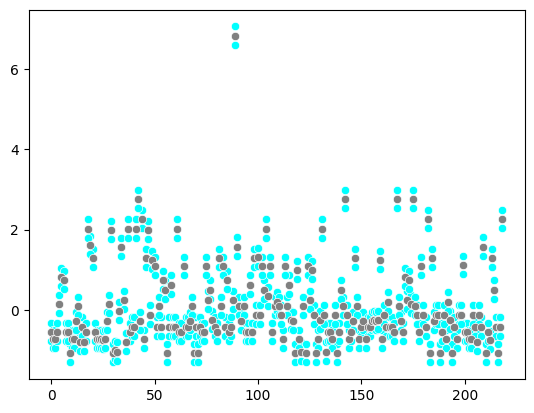

In [76]:
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred+err, color='cyan')
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred-err,  color='cyan')
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred, color="gray")

### c

In [77]:
showing = []
for i in range(1,100,5):
    rr = RandomForestRegressor(n_estimators=i, max_depth=6)
    rr.fit(X_train,y_train)
    showing.append(mean_squared_error(rr.predict(X_test),y_test))

<Axes: >

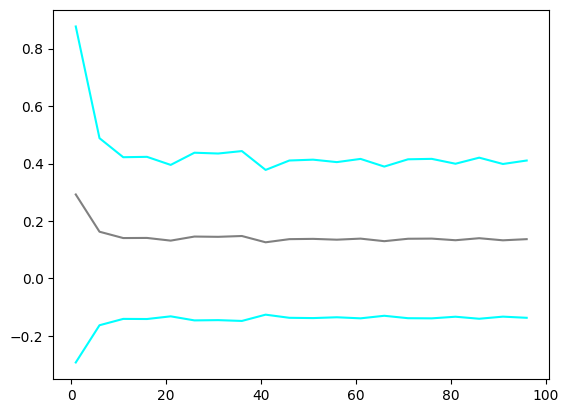

In [78]:
sns.lineplot(x=np.arange(1,100,5),y = showing, color='gray')
sns.lineplot(x=np.arange(1,100,5),y = [2*i + i for i in showing], color='cyan')
sns.lineplot(x=np.arange(1,100,5),y = [-2*i + i for i in showing], color='cyan')

### d

In [79]:
rr = RandomForestRegressor(n_estimators=1, max_depth=9)
rr.fit(X_train,y_train)
pred = rr.predict(X_test)

Интервалы ошибок можно построить в данном случае т.к у нас есть тестовые таргеты. Либо можно использовать сред. ошибку на тесте.

<Axes: >

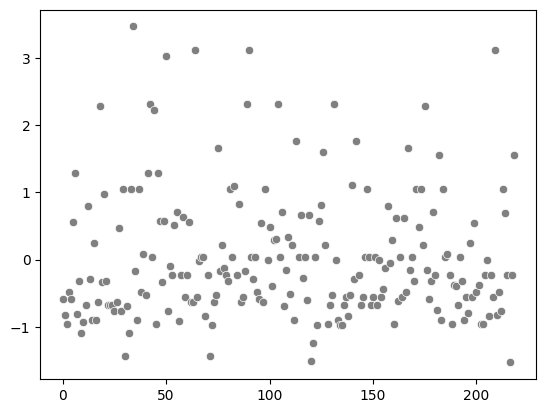

In [80]:
sns.scatterplot(x=np.arange(0,len(pred),1),y = pred, color='gray')

## task 2

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

### a

In [82]:
par = {"max_depth":[1,3,6,8,10], "min_samples_leaf":[1,2,3,4,5]}

out_err = []
out_var = []
tree = DecisionTreeRegressor()
rcv = RandomizedSearchCV(tree, param_distributions=par, n_iter=25)
rcv.fit(X_train,y_train)
tree = DecisionTreeRegressor(**rcv.best_params_)
for i in range(20):
    tree.fit(X_train,y_train)
    cv = cross_validate(tree,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    out_err.append(np.mean(-cv["test_score"]))
    out_var.append(np.var(-cv["test_score"]))

0.23510421903682902  сред ошибка дерева
0.008644287807952686  сред дисперсия


<Axes: >

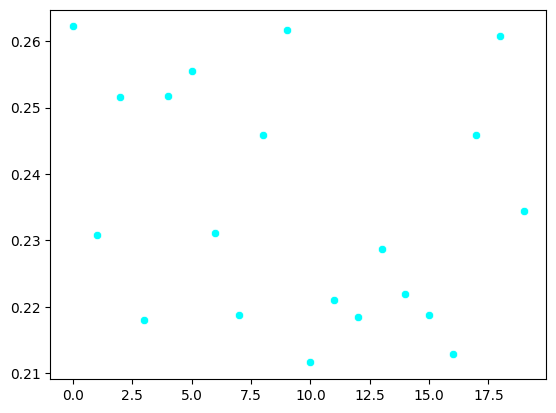

In [83]:
print(np.mean(out_err) , f" сред ошибка дерева")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

видим разброс ошибок для одиночного дерева

### b

In [84]:
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor()

for depth in range(5,15):
    tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=2)
    br = BaggingRegressor(tree, n_estimators=20, max_samples=1., max_features=1., random_state=8)
    cv = cross_validate(br,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    print(f"depth {depth}")
    print(np.mean(-cv["test_score"]), "mean")
    print(np.var(-cv["test_score"]), "var")

depth 5
0.18497510932889852 mean
0.009534389787971699 var
depth 6
0.1712261196213331 mean
0.008802258557879186 var
depth 7
0.16381782279287557 mean
0.008732286057564992 var
depth 8
0.16357021616723208 mean
0.009252895615099396 var
depth 9
0.15936207347310966 mean
0.008959246555292821 var
depth 10
0.15909305421976871 mean
0.00844367353542871 var
depth 11
0.1601304602941459 mean
0.009255656980992413 var
depth 12
0.16027100209465878 mean
0.009276593561171012 var
depth 13
0.16096681174991212 mean
0.009198480809032305 var
depth 14
0.15955254972864155 mean
0.009419082778047691 var


Ошибка и дисперсия уменшились (сильно зависит от рандом состояния) в следствие беггинга. При увеличении глубины точность увеличивается затем имеем переобучение.

### d

In [85]:
from mlxtend.evaluate import bias_variance_decomp

meta = []
tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=2)
for i in range(10,200,20):
    model = BaggingRegressor(tree, n_estimators=i, max_samples=0.5, max_features=0.8, random_state=1)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11
    )
    meta.append((i, bias, var))

Довольно долгое обучение до 500 не получилось. 

In [86]:
def draw_bv(meta):
    sns.lineplot(x=[i[0] for i in meta], y=[i[1] for i in meta],label="bias")
    sns.lineplot(x=[i[0] for i in meta], y=[i[2] for i in meta],label="var")
    plt.plot()

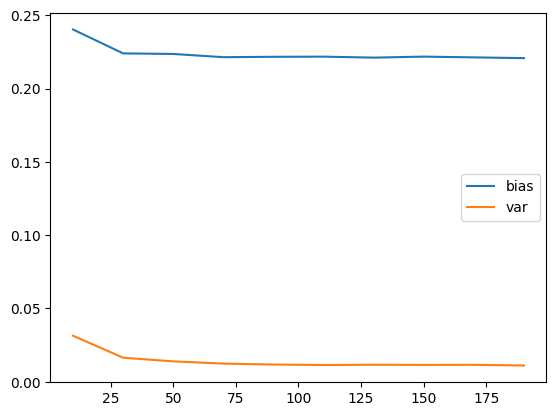

In [87]:
draw_bv(meta)

## task 3

### Шаги из 2

In [88]:
from sklearn.ensemble import RandomForestRegressor

par = {"max_depth":[1,3,6,8,10], "min_samples_leaf":[1,2,3,4,5]}

out_err = []
out_var = []
rf = RandomForestRegressor(n_estimators=1)
rcv = RandomizedSearchCV(rf, param_distributions=par, n_iter=25)
rcv.fit(X_train,y_train)
for i in range(20):
    tree = RandomForestRegressor(n_estimators=1,**rcv.best_params_)
    tree.fit(X_train,y_train)
    cv = cross_validate(tree,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    out_err.append(np.mean(-cv["test_score"]))
    out_var.append(np.var(-cv["test_score"]))

0.319520500953569  сред ошибка дерева
0.024812531597330174  сред дисперсия


<Axes: >

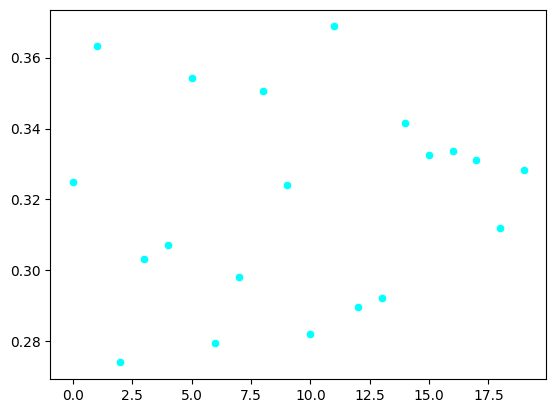

In [89]:
print(np.mean(out_err) , f" сред ошибка дерева")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

In [90]:
for depth in range(5,15):
    tree = RandomForestRegressor(n_estimators=20,max_depth=depth, min_samples_leaf=2,random_state=2332)
    cv = cross_validate(tree,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    print(f"depth {depth}")
    print(np.mean(-cv["test_score"]), "mean")
    print(np.var(-cv["test_score"]), "var")

depth 5
0.20564124478354845 mean
0.015141817455486001 var
depth 6
0.19328271170532713 mean
0.015563577033703691 var
depth 7
0.18031228165952615 mean
0.013085609541810355 var
depth 8
0.17752537615288727 mean
0.012437715341196568 var
depth 9
0.17493257975124066 mean
0.011557932165055311 var
depth 10
0.1767093831168218 mean
0.013425784596815126 var
depth 11
0.173150257203052 mean
0.011414682897752812 var
depth 12
0.17552402541148043 mean
0.013073467613568248 var
depth 13
0.17421751228448018 mean
0.012362629484000269 var
depth 14
0.17783355108388907 mean
0.013382259439132946 var


Ожидаемо точность выше, дисперсия ниже

In [122]:
meta = []
for i in range(10,200,20):
    model = RandomForestRegressor(n_estimators=i,max_depth=9,min_samples_leaf=2)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11
    )
    meta.append((i, bias, var))

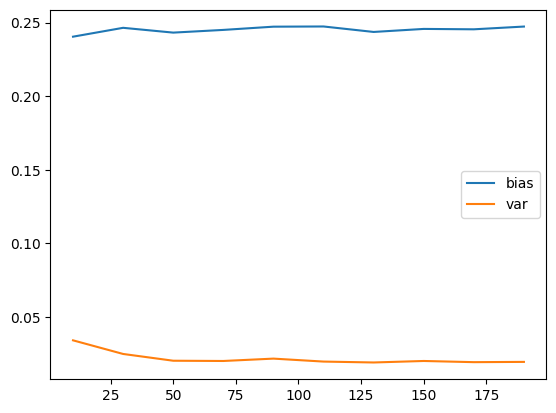

In [123]:
draw_bv(meta)

### a

In [93]:
impot = []
tree = RandomForestRegressor(n_estimators=20, max_depth=6, min_samples_leaf=2, random_state=1)
tree.fit(X_train,y_train)
for num,feat in zip(tree.feature_importances_, X_train.columns):
    impot.append((num,feat))

impot = sorted(impot,reverse=True)
print(impot)
print(mean_squared_error(tree.predict(X_test), y_test), 'all features')

[(0.6408818393971605, 'OverallQual'), (0.08479899901434178, 'GrLivArea'), (0.04183636822228897, '2ndFlrSF'), (0.0286435571980467, '1stFlrSF'), (0.025971989108144983, 'TotalBsmtSF'), (0.014374995477118922, 'LotArea'), (0.012850090440161605, 'FullBath'), (0.012608477635847704, 'BsmtFinSF1'), (0.010081928264411372, 'YearBuilt'), (0.00926917852639231, 'TotRmsAbvGrd'), (0.009134710158556816, 'GarageYrBlt'), (0.00884268820933176, 'ExterQual'), (0.008247327252977497, 'GarageCars'), (0.007361718508145214, 'GarageArea'), (0.006993735952488124, 'LotFrontage'), (0.006720750547555835, 'GarageType'), (0.006652029028653077, 'MoSold'), (0.0061612598130936745, 'Neighborhood'), (0.005621344925248817, 'OpenPorchSF'), (0.005262893907006251, 'YearRemodAdd'), (0.005143041605943235, 'KitchenQual'), (0.004847550641582469, 'OverallCond'), (0.0044725289810409056, 'BsmtQual'), (0.0040536733990292955, 'GarageFinish'), (0.004002462133811522, 'BsmtUnfSF'), (0.0030798620168074153, 'WoodDeckSF'), (0.0025029670711285

In [94]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1299,20,3,75.0,7500,1,3,3,0,4,0,...,0,0,0,0,0,0,5,2010,8,4
575,50,3,80.0,8480,1,3,3,0,4,0,...,0,102,0,0,0,0,10,2008,0,0
1376,30,3,52.0,6292,1,3,0,0,4,0,...,141,0,0,0,0,0,4,2008,8,4
892,20,3,70.0,8414,1,3,3,0,4,0,...,0,0,0,0,0,0,2,2006,8,4
1068,160,4,42.0,3964,1,3,3,0,4,0,...,20,0,0,0,0,0,6,2006,8,4


### b

In [95]:
for o in range(6):
    cat = []
    for i in range(3+o):
        cat.append(impot[i][1])
    tree.fit(X_train[cat],y_train)
    print(cat)
    print(mean_squared_error(tree.predict(X_test[cat]),y_test), f'on {3+o} features')

['OverallQual', 'GrLivArea', '2ndFlrSF']
0.1596386865729338 on 3 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF']
0.16365881662678505 on 4 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF']
0.15799967133755563 on 5 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea']
0.15699545775119625 on 6 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea', 'FullBath']
0.15131788494440018 on 7 features
['OverallQual', 'GrLivArea', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'LotArea', 'FullBath', 'BsmtFinSF1']
0.13001311558388653 on 8 features


Результат лучше чем для всех, видимо очень сильно влияет какие признаки попадут в дерево т.к глубина не сильно большая

### c

*Для сравнения oob и cv попробуем определить оптимальную глубину дерева используя эти оценки

In [126]:
print("cv mse".ljust(38),"| oob".ljust(38), "| depth")
for i in range(5,25):
    model = RandomForestRegressor(n_estimators=50,max_depth=i,min_samples_leaf=2,oob_score=True, random_state=1)
    model.fit(X_train,y_train)
    print(f"{-np.mean(cross_validate(model,X_train,y_train,cv=5,scoring="neg_mean_squared_error")["test_score"])}".ljust(38), f"| {model.oob_score_}".ljust(38), f"| {i}")

cv mse                                 | oob                                  | depth
0.19026686733403864                    | 0.7871680735906081                   | 5
0.1822062436214868                     | 0.7974067558933028                   | 6
0.1740829945480808                     | 0.805673032165235                    | 7
0.17239988053065317                    | 0.8080785348899487                   | 8
0.16949823200903913                    | 0.8128906382011718                   | 9
0.16664352828634246                    | 0.8150471358620756                   | 10
0.167402571956672                      | 0.8115106268771358                   | 11
0.1700729617586964                     | 0.8114241613186395                   | 12
0.16502382647726166                    | 0.8158498170975369                   | 13
0.17214135855418358                    | 0.8092557633951448                   | 14
0.1648697040537474                     | 0.8149157785539392                   | 15
0.1663

Мы видим что однозначного пересечения нет (oob подрузамевает r2 метрику которую мы максимизируем).Но видим, что значения глубины не сильно отличаются. Механизмы довольно похожи, единственное oob получается почти бесплатно в сравнении с перекрестным вычислением cv.
В реальности стоит оценить обе этих метрики, чтобы обоснованнее оценить генерализацию модели.

Посмотрим что у нас на тесте

In [125]:
model = RandomForestRegressor(n_estimators=50,max_depth=15,min_samples_leaf=2,oob_score=True, random_state=1)
model.fit(X_test, y_test)
print(mean_squared_error(model.predict(X_test), y_test), "best depth by cv mse")

model = RandomForestRegressor(n_estimators=50,max_depth=16,min_samples_leaf=2,oob_score=True, random_state=1)
model.fit(X_test, y_test)
print(mean_squared_error(model.predict(X_test), y_test), "best depth by oob r2")

0.049689437067394114 best depth by cv mse
0.049689437067394114 best depth by oob r2


хороший результат в обоих случаях\
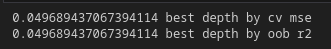\
получились одинаковые результаты (возможно влияние регуляризации через min_samples)

## task 4

По умолчанию mse? Сравним с mae

In [98]:
model1 = RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_leaf=2, criterion="absolute_error")
model2 = RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_leaf=2, criterion="squared_error")

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=50)

In [99]:
pred1 = model1.predict(X_train)
pred2 = model2.predict(X_train)

<Axes: >

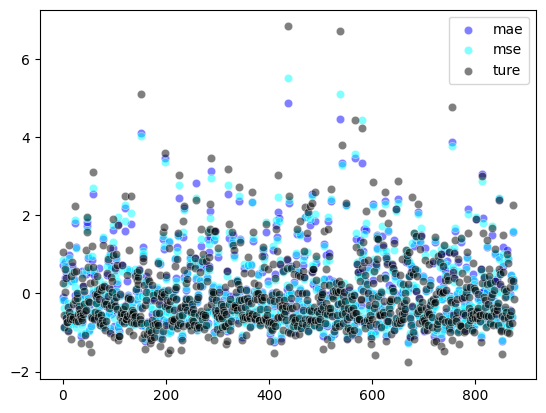

In [100]:
sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred1, color='blue', label="mae", alpha=0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred2,  color='cyan', label="mse", alpha = 0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = y_train, color="black", label="ture", alpha = 0.5)

<Axes: >

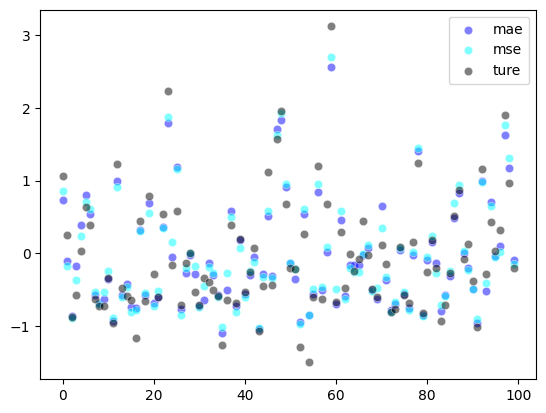

In [101]:
pred1 = pred1[:100]
pred2 = pred2[:100]
y = y_train[:100]

sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred1, color='blue', label="mae", alpha=0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = pred2,  color='cyan', label="mse", alpha = 0.5)
sns.scatterplot(x=np.arange(0,len(pred1),1),y = y, color="black", label="ture", alpha = 0.5)

Видим что mse мение чуствительна к выбросам, как и предполагалось.

## task 5

### шаги из 2 (3ий пункт предполагает их?)

In [102]:
from sklearn.ensemble import AdaBoostRegressor

par = {"max_depth":[1,3,6,8,10], "min_samples_leaf":[1,2,3,4,5]}

out_err = []
out_var = []
rf = RandomForestRegressor(n_estimators=1)
rcv = RandomizedSearchCV(rf, param_distributions=par, n_iter=25)
rcv.fit(X_train,y_train)
tree = RandomForestRegressor(n_estimators=1,**rcv.best_params_,random_state=1)
for i in range(20):
    ada = AdaBoostRegressor(tree, n_estimators=1, learning_rate=0.7,random_state=1)
    ada.fit(X_train,y_train)
    cv = cross_validate(ada,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    out_err.append(np.mean(-cv["test_score"]))
    out_var.append(np.var(-cv["test_score"]))

0.327325105001577  сред ошибка 1 regressor
0.017721995934954597  сред дисперсия


<Axes: >

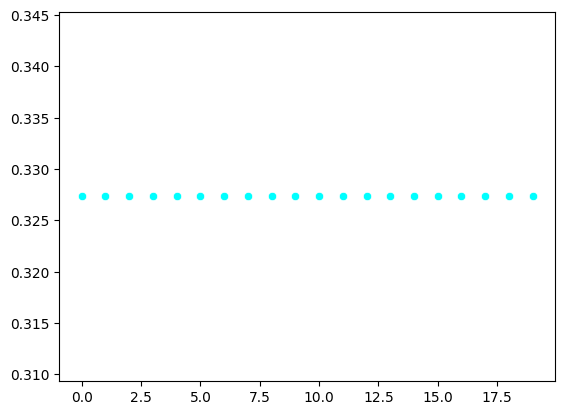

In [103]:
print(np.mean(out_err) , f" сред ошибка 1 regressor")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

Точность от глубины:

In [104]:
for depth in range(5,10):
    tree = RandomForestRegressor(n_estimators=10,max_depth=depth, min_samples_leaf=2,random_state=2332)
    ada = AdaBoostRegressor(tree, n_estimators=10, learning_rate=0.7,random_state=1)
    cv = cross_validate(ada,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    print(f"depth {depth}")
    print(np.mean(-cv["test_score"]), "mean score")
    print(np.var(-cv["test_score"]), "var")

depth 5
0.16401554705151286 mean score
0.009028420657457783 var
depth 6
0.15942710089206422 mean score
0.009284699401764452 var
depth 7
0.151631789403406 mean score
0.008501602641417166 var
depth 8
0.15623719906462188 mean score
0.010749372870451804 var
depth 9
0.1501371619650257 mean score
0.008473243226906773 var


In [105]:
meta = []
for i in range(10,100,10):
    model = RandomForestRegressor(n_estimators=i,max_depth=9,min_samples_leaf=2,random_state=1)
    ada = AdaBoostRegressor(model, n_estimators=10,random_state=1)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11
    )
    meta.append((i, bias, var))

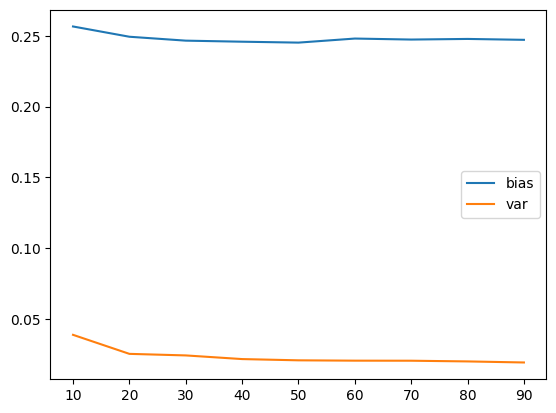

In [106]:
draw_bv(meta)

### шаги из 3

In [107]:
impot = []
tree = RandomForestRegressor(n_estimators=20, max_depth=6, min_samples_leaf=2)
ada = AdaBoostRegressor(tree,n_estimators=10,learning_rate=0.7, random_state=1)
ada.fit(X_train,y_train)
for num,feat in zip(ada.feature_importances_, X_train.columns):
    impot.append((num,feat))

impot = sorted(impot,reverse=True)
print(impot)
print(mean_squared_error(ada.predict(X_test), y_test), 'all features')

[(0.4908144205821659, 'OverallQual'), (0.10051226131051186, 'GrLivArea'), (0.0754423369033797, '2ndFlrSF'), (0.06185409323032942, 'GarageCars'), (0.028587364111939757, 'TotalBsmtSF'), (0.02425122794224719, 'BsmtFinSF1'), (0.024227600120001122, 'Neighborhood'), (0.022168998090438666, '1stFlrSF'), (0.018805188816012768, 'LotArea'), (0.013902468502572407, 'TotRmsAbvGrd'), (0.00993994088792926, 'YearRemodAdd'), (0.009512315051310411, 'LotFrontage'), (0.00949347642507296, 'YearBuilt'), (0.008712798430389655, 'Fireplaces'), (0.008593517701322785, 'GarageArea'), (0.008273594466663934, 'WoodDeckSF'), (0.007906689002905674, 'GarageYrBlt'), (0.00786999132088298, 'OpenPorchSF'), (0.007705905599623685, 'FullBath'), (0.007280507565149618, 'MoSold'), (0.005395511220287947, 'ScreenPorch'), (0.004581377050988861, 'MasVnrArea'), (0.0035080239173483556, 'KitchenQual'), (0.003281806879212525, 'BsmtUnfSF'), (0.0028446447372722328, 'OverallCond'), (0.0026038071864675975, 'ExterQual'), (0.002468830256803171

In [108]:
for o in range(6):
    cat = []
    for i in range(3+o):
        cat.append(impot[i][1])
    ada.fit(X_train[cat],y_train)
    print(cat)
    print(mean_squared_error(ada.predict(X_test[cat]),y_test), f'on {3+o} features')

['OverallQual', 'GrLivArea', '2ndFlrSF']
0.1562285954601434 on 3 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars']
0.14478610110460274 on 4 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF']
0.13767367738437752 on 5 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1']
0.12941477957920722 on 6 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1', 'Neighborhood']
0.13014874266489335 on 7 features
['OverallQual', 'GrLivArea', '2ndFlrSF', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1', 'Neighborhood', '1stFlrSF']
0.12724222468199398 on 8 features


Также хороший результат на меньшем наборе признаков

## task 6

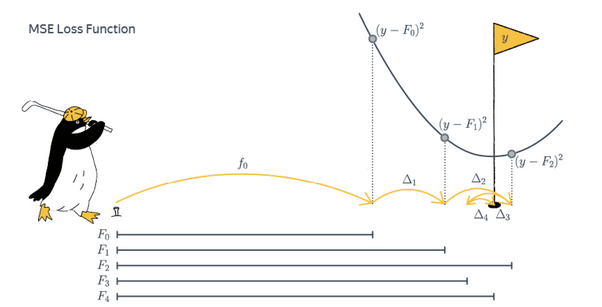

Основная идея заключается в том, что после обучения модели мы находим остатки через Loss функцию и затем обучаем след модель предсказывать ошибки прошлой.\
Формульно: мы строим комозицию из алгоритмов $a(x) = b_1(x) + b_2(x) + ... + b_n(x)$\
Если первый алгоритм обучается используя $\text{argmin}_b \, L(y_i,b(x_i))$ и теперь след алгоритм обучается на ошибках первого и улучшает предсказание.\
И если мы запишем обученеие i_ого алгоритма на ошибках и обобщим на дифф. функцию получим разложение в ряд тейлора:
\begin{equation}
L(y_i, a_k(x_i)) = L(y_i, a_{k-1}(x_i) + b(x_i)) = L(y_i, a_{k-1}(x_i)) + b(x_i)\frac{\delta L(y_i,a_{k-1}(x_i))}{\delta a_{k-1}(x_i)}
\end{equation},
где $a_{k-1}$ композиция на прошлом шаге, $b(x_i)$ ошибка композиции

Покажем на примере, который просто визуализировать

<Axes: xlabel='x', ylabel='y'>

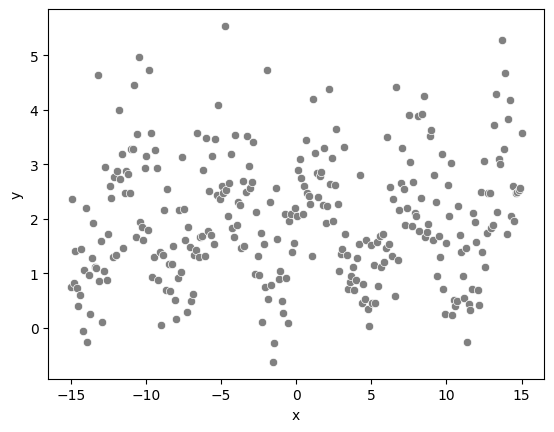

In [109]:
df = pd.DataFrame()
df["x"] = np.linspace(-15, 15, 300)
df["y"] = np.sin(df["x"]) + np.random.gamma(5,0.4,len(df['x']))
sns.scatterplot(x=df["x"], y=df["y"], color = "gray")

Обучим регрессор с 1ой итерацией

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=1,max_depth=6, random_state=1)
x = pd.DataFrame(df['x'])
gbr.fit(x,df['y'])
pred = gbr.predict(x)

<Axes: xlabel='x', ylabel='y'>

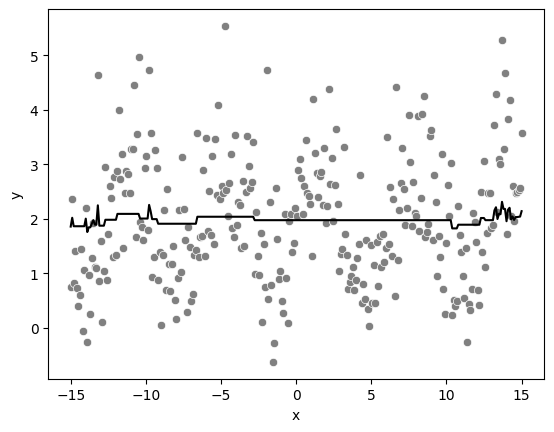

In [111]:
sns.scatterplot(x=df['x'], y=df["y"], color = "gray")
sns.lineplot(x=df['x'],y=pred, color = "black")

Теперь увеличим кол-во шагов обучения

In [112]:
gbr = GradientBoostingRegressor(n_estimators=2,max_depth=6, random_state=1)
x = pd.DataFrame(df['x'])
gbr.fit(x,df['y'])
pred = gbr.predict(x)

<Axes: xlabel='x', ylabel='y'>

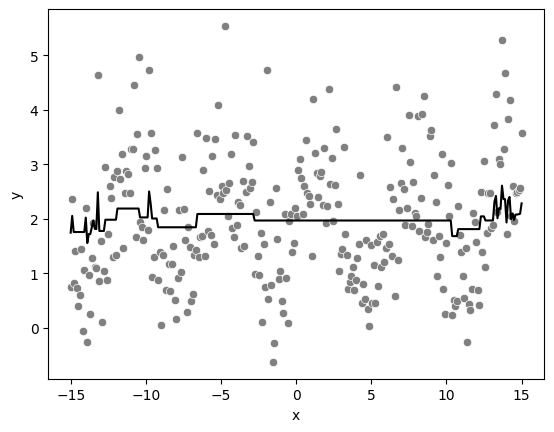

In [113]:
sns.scatterplot(x=df['x'], y=df["y"], color = "gray")
sns.lineplot(x=df['x'],y=pred, color = "black")

Видим что модель улучшает места где плохо отработала прошлая модель и так далее. Нужно быть осторожным т.к модель страдает от переобучения.

## task 7

In [114]:
from xgboost import XGBRegressor

### шаги из 2 (3ий пункт предполагает их?)

In [115]:
out_err = []
out_var = []

for i in range(20):
    model = XGBRegressor(n_estimators=1, learning_rate=0.1, max_depth = 6)
    model.fit(X_train,y_train)
    cv = cross_validate(model, X_train,y_train,cv=10, scoring="neg_mean_squared_error")
    out_err.append(np.mean(-cv["test_score"]))
    out_var.append(np.var(-cv["test_score"]))

0.8510246292666203  сред ошибка деревьев
0.07279078736762952  сред дисперсия


<Axes: >

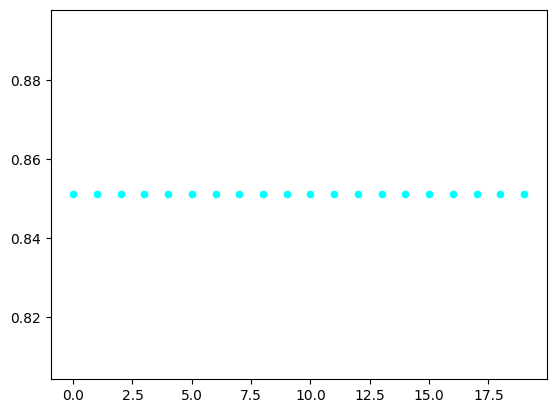

In [116]:
print(np.mean(out_err) , f" сред ошибка деревьев")
print(np.mean(out_var), f" сред дисперсия")
sns.scatterplot(x=np.arange(0,len(out_err),1),y = out_err, color='cyan')

похоже XGboost в случае одного дерева строит самое оптимальное

In [117]:
for depth in range(3,15):
    model = XGBRegressor(n_estimators=20, learning_rate=0.1, max_depth = depth , random_state = 99)
    cv = cross_validate(model,X_train,y_train,cv=10,scoring="neg_mean_squared_error")
    print(f"depth {depth}")
    print(np.mean(-cv["test_score"]), "mean")
    print(np.var(-cv["test_score"]), "var")

depth 3
0.2046533624366312 mean
0.011902224761513144 var
depth 4
0.18729969421182432 mean
0.011781857252515978 var
depth 5
0.18848905524938603 mean
0.014139802683482047 var
depth 6
0.19441284685265076 mean
0.020167182149233995 var
depth 7
0.20317350771358839 mean
0.021695239590224756 var
depth 8
0.20054390683392603 mean
0.018581311165796387 var
depth 9
0.20045243901999704 mean
0.019104455965620964 var
depth 10
0.19986510469478114 mean
0.019500497275567363 var
depth 11
0.2024906927012446 mean
0.01960201168225712 var
depth 12
0.20222289843263314 mean
0.019690071733291115 var
depth 13
0.20250765109771565 mean
0.01941037070241553 var
depth 14
0.20343111006421966 mean
0.01936030077569261 var


In [118]:
meta = []
for i in range(10,100,10):
    model = XGBRegressor(n_estimators=i, learning_rate = 0.1, max_depth=5)
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    mse, bias, var = bias_variance_decomp(model, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=11)
    meta.append((i, bias, var))

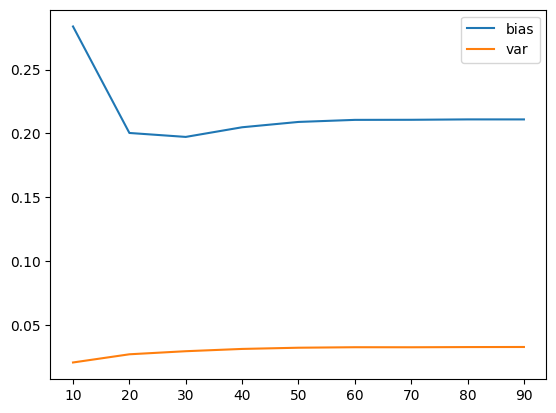

In [119]:
draw_bv(meta)

### шаги из 3

In [120]:
impot = []
model = XGBRegressor(n_estimators=20,learning_rate = 0.1, max_depth=5)
model.fit(X_train,y_train)
for num,feat in zip(model.feature_importances_, X_train.columns):
    impot.append((num,feat))

impot = sorted(impot,reverse=True)
print(impot)
print(mean_squared_error(model.predict(X_test), y_test), 'all features')

[(0.38961634, 'OverallQual'), (0.076495506, 'FullBath'), (0.06395513, 'GarageCars'), (0.033254895, 'Neighborhood'), (0.030556738, 'GrLivArea'), (0.02771137, '1stFlrSF'), (0.026607309, 'GarageFinish'), (0.026527522, '2ndFlrSF'), (0.020640079, 'GarageType'), (0.020330751, 'KitchenAbvGr'), (0.019727139, 'TotalBsmtSF'), (0.015747877, 'BsmtQual'), (0.015474187, 'KitchenQual'), (0.0146437185, 'GarageArea'), (0.013902131, 'Fireplaces'), (0.013759221, 'TotRmsAbvGrd'), (0.013704853, 'WoodDeckSF'), (0.010136683, 'HalfBath'), (0.010038334, 'YearRemodAdd'), (0.009218438, 'BsmtFinSF1'), (0.0091871135, 'YearBuilt'), (0.0089341495, 'LandContour'), (0.008379367, 'MSZoning'), (0.008219336, 'MasVnrArea'), (0.007880527, 'HeatingQC'), (0.0076543647, 'Exterior2nd'), (0.0071151354, 'HouseStyle'), (0.007016268, 'LotFrontage'), (0.00648708, 'ExterQual'), (0.0063888216, 'CentralAir'), (0.006148628, 'LandSlope'), (0.005972443, 'LotArea'), (0.0058454326, 'OverallCond'), (0.005764699, 'BsmtFullBath'), (0.00536405

In [121]:
for o in range(6):
    cat = []
    for i in range(3+o):
        cat.append(impot[i][1])
    model.fit(X_train[cat],y_train)
    print(cat)
    print(mean_squared_error(model.predict(X_test[cat]),y_test), f'on {3+o} features')

['OverallQual', 'FullBath', 'GarageCars']
0.2252713855790656 on 3 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood']
0.21286966016106226 on 4 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea']
0.17356908080270922 on 5 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea', '1stFlrSF']
0.16559242948251973 on 6 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea', '1stFlrSF', 'GarageFinish']
0.16329243839398497 on 7 features
['OverallQual', 'FullBath', 'GarageCars', 'Neighborhood', 'GrLivArea', '1stFlrSF', 'GarageFinish', '2ndFlrSF']
0.16594336981832772 on 8 features


Видим не такой значительный прирост как в примере 3. Видимо XGBoost хитро выбирает признаки.

no oob ;(